## Two-level classification with deep learning neural network
The idea of this notebook is to demonstrate how to test different algorithms with hyperparameter tuning to train a model and how to evaluate a model that has two-level architecture which is a redacted version on my work on a very specific dataset on a totally unrelated topic.


This the Deep Learning neural network version of the two-level architecture model. It has a simple configure without hyperparameter tuning or earlystopping. Cross validation was used instead of validation set.

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

### 1. Dataset Preparation steps

In [2]:
# Download IRIS dataset for classification problem
from sklearn import datasets
iris = datasets.load_iris()

# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),0
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
df = df.rename(columns = {0:'species'})

In [4]:
print(df.columns.tolist())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']


In [5]:
# If we need to remove any unwanted columns
param_to_remove = ['sepal length (cm)', 'sepal length (cm)']
for col in df.columns.tolist():
    if '(c' in col or 'm)' in col:
        param_to_remove.append(col)

others_to_remove = []

remove_list = param_to_remove + others_to_remove

In [6]:
# Reload the DataFrame
# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df = df.rename(columns = {0:'species'})
df.shape

(150, 5)

In [7]:
# adding three more random label columns
num_rows = df.shape[0]

new_cols = {'Label_1': np.random.choice(['A', 'B', 'C', 'D'], size=num_rows),
            'Label_2': np.random.choice(['A2', 'A2', 'C', 'D'], size=num_rows),
            'Label_3': np.random.choice(['B2', 'B', 'C', 'D'], size=num_rows)}

df = df.assign(**new_cols)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,5.1,3.5,1.4,0.2,0,B,A2,C
1,4.9,3.0,1.4,0.2,0,C,C,D
2,4.7,3.2,1.3,0.2,0,C,A2,B
3,4.6,3.1,1.5,0.2,0,D,C,C
4,5.0,3.6,1.4,0.2,0,C,A2,D


In [8]:
# More columns and rows filtering can be done here, in the original data there are others
df["Label_2"] = df.apply(lambda x: 'A' if 'A' in x["Label_2"] else x["Label_2"], axis=1)
df["Label_3"] = df.apply(lambda x: 'B' if 'B' in x["Label_3"] else x["Label_3"], axis=1)

In [9]:
# check for null values, in this case there isn't any because it's a dummy dataset
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [10]:
#Create a new column that collects every labels that exist in a row (except when it's A) which will be used for stratification
key_types = ['species', 'Label_1', 'Label_2', 'Label_3']
df["labels"] = df.apply(lambda x: ','.join(x[x.index.isin(key_types)].index
                                           [x[x.index.isin(key_types)] != 'A' ]), axis=1)

#### Split the df into final_test_set and global_train_set using defect combination

In [11]:
# Find row with a unique combination of labels that only have one sample which will create problem during split
df["labels"].value_counts().loc[lambda x: x<2]

Series([], Name: labels, dtype: int64)

In [12]:
# Get the row that have unique combination (we will add them to the test set), before dropping them from the main df
unique_combination_ind = df["labels"].value_counts().loc[lambda x: x<2].index
unique_combination_df = df[df["labels"].isin(unique_combination_ind)]

#print(unique_combination_df)

# drop rows with unique_combination
print("before drop: ", df.shape)
df = df.drop(df[df["labels"].isin(unique_combination_ind)].index).reset_index(drop=True)
print("after drop: ", df.shape)

before drop:  (150, 9)
after drop:  (150, 9)


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["labels"]):
    Global_train_set = df.loc[train_index]
    Final_test_set_original = df.loc[test_index]

In [15]:
# Add the unique combination rows to the Final_test_set
Final_test_set_original = pd.concat([Final_test_set_original, unique_combination_df], ignore_index=True)

Final_test_set_original["labels"].value_counts()

species,Label_1,Label_2,Label_3    12
species,Label_1,Label_3            11
species,Label_2,Label_3             4
species,Label_3                     3
Name: labels, dtype: int64

In [16]:
# Drop the labels colmun from test and train sets
Global_train_set = Global_train_set.drop("labels", axis=1)
Final_test_set_original = Final_test_set_original.drop("labels", axis=1)

In [17]:
Global_train_set.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
48,5.3,3.7,1.5,0.2,0,B,C,D
79,5.7,2.6,3.5,1.0,1,B,D,B
4,5.0,3.6,1.4,0.2,0,C,A,D
8,4.4,2.9,1.4,0.2,0,B,A,D
40,5.0,3.5,1.3,0.3,0,C,A,B


#### End final test set split

# Classifier A training

### 2. Preparing the train set

In [18]:
df = Global_train_set.copy()

In [19]:
# Create the 'species_not_0' column where 0 for species is 0, and 1 is for the others
df["species_not_0"] = df.apply(lambda x: 0 if x['species'] == 0 else 1, axis=1)
#df[['Niv_Type','Nall_Type',"long_defect_cat"]]

In [20]:
# Drop the 'species' column
df.drop(['species']
        , axis=1, inplace=True)
print(df.columns.tolist())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'Label_1', 'Label_2', 'Label_3', 'species_not_0']


In [21]:
# Find if there is any column that is not numeric 
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.head()

,Label_1,Label_2,Label_3
48,B,C,D
79,B,D,B
4,C,A,D
8,B,A,D
40,C,A,B


In [22]:
# Add categorical columns that are number manually can convert them to categorical type
other_cat_col = []
df[other_cat_col] = df[other_cat_col].astype("category")
df[other_cat_col].dtypes

Series([], dtype: object)

In [23]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [24]:
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
#print(df_cat_encoded)

df[df_cat.columns.tolist()] = df_cat_encoded
df[df_cat.columns.tolist()] = df[df_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

end of step 1.

### 3. Oversampling the train set

In [26]:
y_train = df["species_not_0"]
X_train = df.drop("species_not_0", axis=1)
y_train.value_counts()

1    80
0    40
Name: species_not_0, dtype: int64

In [27]:
#We check the ratio of the labels
df["species_not_0"].value_counts() / len(df)

1    0.666667
0    0.333333
Name: species_not_0, dtype: float64

We want more class 0 so use oversampling to make it 50:50

In [28]:
from collections import Counter
counter = Counter(y_train)
print('Before oversampling', counter)

Before oversampling Counter({1: 80, 0: 40})


In [29]:
oversampling = True

In [30]:
if oversampling:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy=0.8, random_state = 42) # sampling_strategy = float only works for Binary 
    
    X_train_pre_transf, y_train_pre_transf = smote.fit_resample(X_train, y_train)
    counter = Counter(y_train_pre_transf)
    print('After', counter)
else:
    X_train_pre_transf = X_train
    y_train_pre_transf = y_train

After Counter({1: 80, 0: 64})


In [31]:
#print(X_train_pre_transf[df_cat.columns.tolist()].value_counts())
X_train_pre_transf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label_1,Label_2,Label_3
0,5.3,3.7,1.5,0.2,1.0,1.0,2.0
1,5.7,2.6,3.5,1.0,1.0,2.0,0.0
2,5.0,3.6,1.4,0.2,2.0,0.0,2.0
3,4.4,2.9,1.4,0.2,1.0,0.0,2.0
4,5.0,3.5,1.3,0.3,2.0,0.0,0.0


end of step 3.

### 4. Transformation

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer

In [33]:
X_train_set = X_train_pre_transf.copy()

In [34]:
cat_attribs = X_train_set.select_dtypes(include='category').columns.tolist()
#print(cat_attribs)

X_train_num_lst = X_train_set.drop(cat_attribs, axis=1).columns.tolist()
X_train_cat_lst = X_train_set[cat_attribs].columns.tolist()

print(X_train_num_lst)
print(X_train_cat_lst)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['Label_1', 'Label_2', 'Label_3']


In [35]:
# Create a transforamtion class to add, combine, fuse, extract features for the numeric PL
# stat_feature_head_to_tail is to use only the absolute 'ab_maximum' or 'average' value of each statistical features  
class Attrib_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, stat_features = 'ab_maximum'):
        self.stat_features = stat_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.stat_features is not None:
            stat_feature = ['sepal', 'petal']
            measurement = ['length', 'width']
            
            new_X = X.copy() # so the original df is not changed
            # See the commnad line argument and match it to pre-defined case 
            match self.stat_features:
                case 'ab_maximum':
                    for stat in stat_features:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        
                        # Get the absolute maximum value of each row, keep the sign, and put them in a new colmun
                        col_name = measure + '_' + self.stat_features
                        row_max = X[meaurement_list].abs().max(axis=1)
                        new_X[col_name] = X[meaurement_list].max(axis=1).mask(lambda x: x < row_max, -row_max)
                        new_X = new_X.drop(meaurement_list, axis=1)
                
                case 'average':
                    for stat in stat_feature:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        # Get the mean value of each row and put them in a new colmun 
                        col_name = measure + '_' + self.stat_features
                        new_X[col_name] = X[meaurement_list].mean(axis=1)
                        new_X = new_X.drop(meaurement_list, axis=1)
                    
                case _:   # 'case _' is for any other input that does not match None or the above
                    sys.exit("please choose from 'ab_maximum', 'average', or \
                    'None' for stat_featurs in Attrib_transformer")
                
            #print(list(new_X.columns))
            return new_X
            
        else:
            return X


In [37]:
# Create a transforamtion class to drop unwanted features
class Attrib_drop(BaseEstimator, TransformerMixin):
    def __init__(self, d_list=[], keep_only_length=False):
        self.d_list = d_list
        self.keep_only_length = keep_only_length
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.keep_only_length:
            Vert_acc_indices = []
            for i, col in enumerate(X.columns):
                if 'length' in col:
                    length_indices.append(i)
            return X.iloc[:,length_indices]
        elif self.d_list:
            keep_indices = []
            for i, col in enumerate(X.columns):
                if col not in self.d_list:
                    keep_indices.append(i)
            return X.iloc[:,keep_indices]
        else:
            return X

In [38]:
# List of the numerical features to be dropped to manually drop columns from the df
drop_list_num = [] # Here we can add columns that should be dropped from the df

num_pl = Pipeline([
    #('imputer', SimpleImputer(strategy="median")),
    ('attrib_transform', Attrib_transformer(stat_features='average')),
    ('attrib_drop', Attrib_drop(keep_only_length=False, d_list=drop_list_num)),
    ('std_scaler', StandardScaler()),
])

#For testing num_pl
#num_prep = num_pl.fit_transform(X_train_set[X_train_num_lst])
#print('shape after transformation: ', num_prep.shape)
#num_prep

In [39]:
# List of the categorical features to be dropped to manually drop columns from the df
drop_list_cat = []

cat_pl = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('attrib_drop', Attrib_drop()),
    ('One_Hot', OneHotEncoder(sparse_output=False)),
])

# For testing cat_pl
#cat_prep = cat_pl.fit_transform(X_train_set[X_train_cat_lst])
#cat_prep

In [41]:
full_pl = ColumnTransformer([
    ("num", num_pl, X_train_num_lst),
    ("cat", cat_pl, X_train_cat_lst),
])

X_train_prep = full_pl.fit_transform(X_train_set)

In [42]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (144, 14)


array([[-1.05159037,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.04451338,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.09073693,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.08323635,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.06351495,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.93032716,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

#### 5.1 OPTIONAL: PCA for unsupervised feature selectiion

In [43]:
use_PCA = True

if use_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False)
    
    X_train_prep = pca.fit_transform(X_train_prep)
    print('number of components: ', pca.n_components_)

number of components:  8


In [44]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (144, 8)


array([[-1.09805594,  1.17769297,  0.09148454, ..., -0.31654847,
        -0.61400918, -0.32145889],
       [ 0.20990531, -0.29265835,  0.55152955, ..., -0.56281949,
        -0.34689318,  0.35405377],
       [-1.29050499,  0.17828898, -0.43321633, ...,  0.1568344 ,
        -0.1923717 ,  0.63740521],
       ...,
       [-1.13439127,  0.58871752,  0.42358495, ...,  0.1045601 ,
         0.1495049 , -0.68926337],
       [-1.10806038,  0.47075401,  0.54972159, ...,  0.16748368,
         0.28319471, -0.18831427],
       [-1.04204352, -0.33828258, -0.34555695, ...,  0.83296452,
        -0.03698023, -0.37605596]])

### 6. Train NN

In [50]:
#pip install scikeras --user
#pip install tensorflow --user

In [51]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

In [55]:
# Define a function to build the neural network model
def build_model(n_hidden=9, n_neurons=64, lr=3e-3, rho=0.9, inputshape=X_train_prep.shape[1]):
    model = keras.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal", input_shape=(inputshape,))
    ])

    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"))
        model.add(keras.layers.AlphaDropout(rate=0.15))

    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=rho)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create a KerasClassifier wrapper for the model
model = KerasClassifier(model=build_model, epochs=50, batch_size=32, verbose=0)

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [57]:
# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_prep, y_train_pre_transf, cv=cv, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")

# Calculate mean and standard deviation of cross-validation scores
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean Accuracy: {mean_score}")
print(f"Standard Deviation: {std_score}")

Cross-Validation Scores:
Fold 1: 1.0
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
Mean Accuracy: 1.0
Standard Deviation: 0.0


In [58]:
# Fit the model with the complete training set
model.fit(X_train_prep, y_train_pre_transf, epochs=200, batch_size=32)

KerasClassifier(
	model=<function build_model at 0x000001CB358BBA30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

 # Classifier 2-B

### 2. Data Preparation

In [59]:
df = Global_train_set.copy()

In [60]:
df = df.drop(df[(df['species'] == 0)].index).reset_index(drop=True)

In [61]:
df["species"].value_counts()

1    40
2    40
Name: species, dtype: int64

In [62]:
# Find if there is any column that is not numeric 
df_cat = df.select_dtypes(exclude=[np.number])
#df_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
other_cat_col = []
df[other_cat_col] = df[other_cat_col].astype("category")
#df[other_cat_col].dtypes

In [63]:
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
#print(df_cat_encoded)

df[df_cat.columns.tolist()] = df_cat_encoded
df[df_cat.columns.tolist()] = df[df_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

In [64]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,5.7,2.6,3.5,1.0,1,1.0,2.0,0.0
1,5.8,2.7,5.1,1.9,2,0.0,2.0,0.0
2,6.5,3.0,5.2,2.0,2,3.0,2.0,0.0
3,6.7,3.3,5.7,2.5,2,0.0,2.0,1.0
4,4.9,2.4,3.3,1.0,1,3.0,1.0,2.0


In [65]:
y_train = df["species"]
X_train = df.drop("species", axis=1)
y_train.value_counts()

1    40
2    40
Name: species, dtype: int64

### 3. Oversampling

In [66]:
counter = Counter(y_train)
print('Before oversampling', counter)

Before oversampling Counter({1: 40, 2: 40})


In [67]:
oversampling = False

if oversampling:
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(sampling_strategy=1, random_state = 42)# sampling_strategy = float only works for Binary 
    
    X_train_pre_transf, y_train_pre_transf = ada.fit_resample(X_train, y_train)
    counter = Counter(y_train_pre_transf)
    print('After', counter)
else:
    X_train_pre_transf = X_train
    y_train_pre_transf = y_train

### 3. Transformation

In [68]:
X_train_set = X_train_pre_transf.copy()

In [69]:
cat_attribs = X_train_set.select_dtypes(include='category').columns.tolist()
#print(cat_attribs)

X_train_num_lst = X_train_set.drop(cat_attribs, axis=1).columns.tolist()
X_train_cat_lst = X_train_set[cat_attribs].columns.tolist()

#print(X_train_num_lst)
#print(X_train_cat_lst)

In [70]:
# Create a transforamtion class to drop unwanted features
class Attrib_drop_2_B(BaseEstimator, TransformerMixin):
    def __init__(self, d_list=[], keep_only_width=False):
        self.d_list = d_list
        self.keep_only_width = keep_only_width
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.keep_only_width:
            Lat_acc_indices = []
            for i, col in enumerate(X.columns):
                if 'width' in col:
                    width_indices.append(i)
            return X.iloc[:,width_indices]
        elif self.d_list:
            keep_indices = []
            for i, col in enumerate(X.columns):
                if col not in self.d_list:
                    keep_indices.append(i)
            return X.iloc[:,keep_indices]
        else:
            return X

In [71]:
# List of the numerical features to be dropped to manually drop columns from the df

drop_list_num_2_B = []


num_pl_2_B = Pipeline([
    #('imputer', SimpleImputer(strategy="median")),
    ('attrib_transform', Attrib_transformer(stat_features='average')),
    ('attrib_drop', Attrib_drop_2_B(keep_only_width=False, d_list=drop_list_num_2_B)),
    ('std_scaler', StandardScaler()),
])

#For testing num_pl
#num_prep = num_pl.fit_transform(X_train_set[X_train_num_lst])
#print('shape after transformation: ', num_prep.shape)
#num_prep

In [72]:
# List of the categorical features to be dropped to manually drop columns from the df
drop_list_cat_2_B = ['Lane']

cat_pl_2_B = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('attrib_drop', Attrib_drop_2_B(d_list=drop_list_cat_2_B)),
    ('One_Hot', OneHotEncoder(sparse_output=False)),
])

# For testing cat_pl
#cat_prep = cat_pl.fit_transform(X_train_set[X_train_cat_lst])
#cat_prep

In [73]:
full_pl_2_B = ColumnTransformer([
    ("num", num_pl_2_B, X_train_num_lst),
    ("cat", cat_pl_2_B, X_train_cat_lst),
])

X_train_prep = full_pl_2_B.fit_transform(X_train_set)

### 4. PCA

In [74]:
use_PCA = True

if use_PCA:
    from sklearn.decomposition import PCA
    pca_2_B = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False)
    
    X_train_prep = pca_2_B.fit_transform(X_train_prep)
    print('number of components: ', pca_2_B.n_components_)

number of components:  7


In [75]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (80, 7)


array([[-1.73669264,  0.0030476 ,  0.6456964 , -1.05741759,  0.09125945,
        -0.05513898, -0.16331277],
       [ 0.49573964, -0.33293969,  0.73002507, -0.53516165,  0.60445052,
         0.52120494,  0.48437926],
       [ 0.54935665, -0.21566848,  1.15191844,  0.07856177,  0.35785379,
        -0.44139828, -0.17477044],
       [ 1.59047678,  0.31786644,  0.65309749, -0.27119067,  0.04857793,
         1.25037693, -0.15051832],
       [-1.8058352 ,  1.22597379,  0.12709945,  0.7510166 , -0.05745243,
        -0.32913237,  0.55573236],
       [ 1.35591716, -0.03177878, -0.26622587, -0.4257612 ,  0.50311839,
        -0.01438891,  0.86417972],
       [-0.91480687, -0.25593592,  0.74972676, -0.53764048,  0.67469597,
         0.66778631,  0.54844117],
       [-1.02713651, -0.12960546,  1.17393798,  0.07579131,  0.43636341,
        -0.27757205, -0.10317183],
       [-0.69448455,  1.00484059, -0.41473397, -0.6856501 , -0.52049233,
         0.23328593, -0.37695805],
       [ 1.14541253, -0.8654

### 5. Train the classifier

In [78]:
# Define a function to build the neural network model
def build_model_2_B(n_hidden=9, n_neurons=64, lr=3e-3, rho=0.9, inputshape=X_train_prep.shape[1]):
    model_2_B = keras.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal", input_shape=(inputshape,))
    ])

    for _ in range(n_hidden):
        model_2_B.add(keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"))
        model_2_B.add(keras.layers.AlphaDropout(rate=0.15))

    model_2_B.add(keras.layers.Dense(1, activation="sigmoid"))
    
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=rho)

    model_2_B.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model_2_B

# Create a KerasClassifier wrapper for the model
model_2_B = KerasClassifier(model=build_model_2_B, epochs=50, batch_size=32, verbose=0)

In [79]:
# Perform cross-validation
scores_2_B = cross_val_score(model_2_B, X_train_prep, y_train_pre_transf, cv=cv, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:")
for i, score in enumerate(scores_2_B):
    print(f"Fold {i+1}: {score}")

# Calculate mean and standard deviation of cross-validation scores
mean_score_2_B = np.mean(scores_2_B)
std_score_2_B = np.std(scores_2_B)
print(f"Mean Accuracy: {mean_score_2_B}")
print(f"Standard Deviation: {std_score_2_B}")

Cross-Validation Scores:
Fold 1: 0.9375
Fold 2: 1.0
Fold 3: 0.875
Fold 4: 0.9375
Fold 5: 0.75
Mean Accuracy: 0.9
Standard Deviation: 0.08477912478906585


In [80]:
# Fit the model with the complete training set
model_2_B.fit(X_train_prep, y_train_pre_transf, epochs=200, batch_size=32)

KerasClassifier(
	model=<function build_model_2_B at 0x000001CB354CDAB0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

# Final evalution using Final_test_set

### 1. Prepare Final_test_set

In [81]:
Final_test_set = Final_test_set_original.copy()

In [82]:
Final_test_set.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,6.0,2.9,4.5,1.5,1,B,A,C
1,6.4,2.8,5.6,2.1,2,D,D,B
2,7.7,2.6,6.9,2.3,2,A,D,B
3,5.1,3.5,1.4,0.3,0,D,C,C
4,5.6,2.5,3.9,1.1,1,A,C,B


### 2. Make prediction with classifier 2-A 

In [83]:
# Find if there is any column that is not numeric 
Final_test_set_cat = Final_test_set.select_dtypes(exclude=[np.number])
#Final_test_set_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
Final_test_set[other_cat_col] = Final_test_set[other_cat_col].astype("category")
#df[other_cat_col].dtypes

In [84]:
Final_test_set_cat_encoded = ordinal_encoder.fit_transform(Final_test_set_cat)
#print(df_cat_encoded)

Final_test_set[Final_test_set_cat.columns.tolist()] = Final_test_set_cat_encoded
Final_test_set[df_cat.columns.tolist()] = Final_test_set[Final_test_set_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

In [87]:
Final_test_A = Final_test_set.copy()

In [88]:
Final_test_A["true_A"] = Final_test_A.apply(lambda x:
                                            0 if
                                            x["species"] == 0
                                            else 1, axis=1)

In [89]:
Final_test_A["true_A"].value_counts()

1    20
0    10
Name: true_A, dtype: int64

In [90]:
X_Final_test_A = Final_test_A.drop("species", axis=1)
y_Final_test_A = Final_test_A["true_A"]

In [91]:
#Transform the X_test as the train set has been transformed
X_Final_test_A_prep = full_pl.transform(X_Final_test_A)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_Final_test_A_prep = pca.transform(X_Final_test_A_prep)
    print('number of components: ', pca.n_components_)

print('shape after transformation: ', X_Final_test_A_prep.shape)

number of components:  8
shape after transformation:  (30, 8)


In [96]:
y_Final_test_A_pred = model.predict(X_Final_test_A_prep)

In [97]:
Final_test_set["A_label"] = y_Final_test_A_pred

In [98]:
Final_test_set[["species", "A_label"]].head(10)

,species,A_label
0,1,1
1,2,1
2,2,1
3,0,0
4,1,1
5,0,0
6,2,1
7,1,1
8,2,1
9,0,0


### 3. Prepare a set for 2-B by only keeping the rows that A predict as 1

In [100]:
# get index of rows with A_label = 1
label_1_by_A_ind = Final_test_set[Final_test_set["A_label"] == 1].index

In [101]:
Final_test_set.iloc[label_1_by_A_ind].head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3,A_label
0,6.0,2.9,4.5,1.5,1,1.0,0.0,1.0,1
1,6.4,2.8,5.6,2.1,2,3.0,2.0,0.0,1
2,7.7,2.6,6.9,2.3,2,0.0,2.0,0.0,1
4,5.6,2.5,3.9,1.1,1,0.0,1.0,0.0,1
6,7.1,3.0,5.9,2.1,2,1.0,0.0,1.0,1
7,6.0,2.7,5.1,1.6,1,3.0,1.0,0.0,1
8,6.0,2.2,5.0,1.5,2,1.0,0.0,1.0,1
10,6.6,2.9,4.6,1.3,1,2.0,2.0,1.0,1
11,7.2,3.6,6.1,2.5,2,1.0,1.0,1.0,1
12,6.5,2.8,4.6,1.5,1,3.0,1.0,0.0,1


In [102]:
Final_test_2_B = Final_test_set.iloc[label_1_by_A_ind,:]

Final_test_2_B["A_label"].value_counts()

1    20
Name: A_label, dtype: int64

### 4. Make prediction with classifier 2-B

In [103]:
Final_test_2_B[["species","A_label"]].tail(10)

,species,A_label
14,1,1
15,1,1
16,2,1
19,2,1
20,2,1
21,2,1
22,2,1
24,1,1
26,1,1
28,1,1


In [104]:
X_Final_test_2_B = Final_test_2_B.drop(["species","A_label"], axis=1)
y_Final_test_2_B = Final_test_2_B["species"]

In [105]:
#Transform the X_test as the train set has been transformed
X_Final_test_2_B_prep = full_pl_2_B.transform(X_Final_test_2_B)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_Final_test_2_B_prep = pca_2_B.transform(X_Final_test_2_B_prep)
    print('number of components: ', pca_2_B.n_components_)

print('shape after transformation: ', X_Final_test_2_B_prep.shape)

number of components:  7
shape after transformation:  (20, 7)


In [108]:
y_Final_test_2_B_pred = model_2_B.predict(X_Final_test_2_B_prep)

In [109]:
y_Final_test_2_B_pred

array([1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1])

### 5. Integrate the prediction back to Final_test_set and evaluate

In [110]:
Final_test_set[["2_B_label"]] = 0
Final_test_set.iloc[label_1_by_A_ind, -1] = y_Final_test_2_B_pred

In [111]:
Final_test_set[["species", "A_label", "2_B_label"]].tail(10)

,species,A_label,2_B_label
20,2,1,2
21,2,1,2
22,2,1,2
23,0,0,0
24,1,1,1
25,0,0,0
26,1,1,1
27,0,0,0
28,1,1,1
29,0,0,0


In [114]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys

In [115]:
def perf_evaluate_plot(y_test, y_pred, model = 1):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Define class names
    if model == 1:
        classes = ['Class 0', 'Class 1']
    elif model == 2:
        classes = ['Class 1', 'Class 2']
    elif model == 3:
        classes = ['Class 0', 'Class 1', 'Class 2']
    else:
        sys.exit("n_class can only be 2 or 3")
    
    # Define plot parameters
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":16})
    
    # Set plot labels
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    # Create classification report
    print(classification_report(y_test, y_pred))
    print("====================================================================================")

A performance evaluation


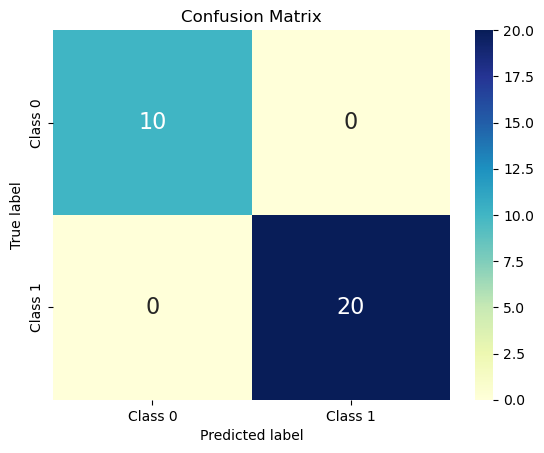

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

2-B performance evaluation


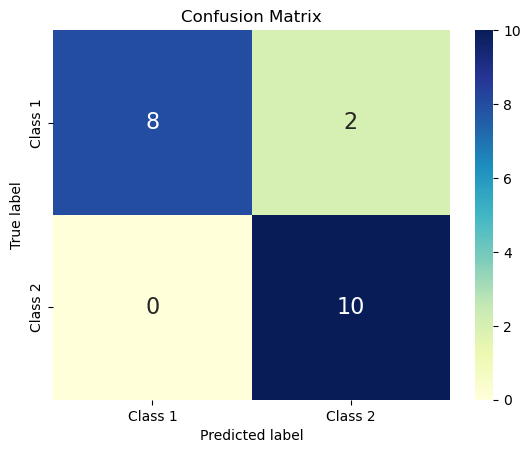

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Model net performance evaluation


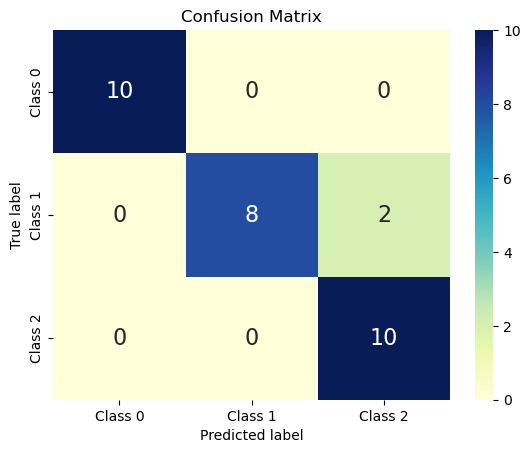

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [116]:
# classifier 2-A alone
print("A performance evaluation")
perf_evaluate_plot(y_Final_test_A, y_Final_test_A_pred, model=1)

# classifier 2-B alone
print("2-B performance evaluation")
perf_evaluate_plot(y_Final_test_2_B, y_Final_test_2_B_pred, model=2)

# Net performance
print("Model net performance evaluation")
perf_evaluate_plot(Final_test_set["species"], Final_test_set["2_B_label"], model=3)

#### Final words


The result is pretty good at the first level (classifier A). However, we see some false negative for class 2 in the classifer 2-B (while it is still not too bad). Tbh, IRIS dataset is a simple classification problem and the test set is small to further analyse the errors. The performance of the first level is perfect, so we do not see the error propagation effect which is a result of class 0 leaking into the second classifier that was not trained to classify them in this example, nevertheless, it has significant effect of the performance of the model when it happens. 

Anyways, the idea of this notebook is to demonstrate how to test different algorithms with hyperparameter tuning to train a model and how to evaluate a model that has two-level architecture which is a redacted version on my work on a very specific dataset on a totally unrelated topic.